In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



**Vggish training code:**

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip install numpy scipy
!pip install resampy tensorflow six

  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=75482f2d46839148c2b1fda2ed0c2534d546aadcec6a6619aed7d2a29f22d5d5
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


In [ ]:
!git clone https://github.com/tensorflow/models.git


Cloning into 'models'...
remote: Enumerating objects: 41935, done.
remote: Total 41935 (delta 0), reused 0 (delta 0), pack-reused 41935
Receiving objects: 100% (41935/41935), 549.25 MiB | 46.93 MiB/s, done.
Resolving deltas: 100% (28498/28498), done.


In [ ]:
# Check to see where are in the kernel's file system.
!pwd

/content


In [ ]:
# Grab the VGGish model
!curl -O https://storage.googleapis.com/audioset/vggish_model.ckpt
!curl -O https://storage.googleapis.com/audioset/vggish_pca_params.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  277M  100  277M    0     0  90.1M      0  0:00:03  0:00:03 --:--:-- 90.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73020  100 73020    0     0   300k      0 --:--:-- --:--:-- --:--:--  299k


In [ ]:
!ls

In [ ]:
# Verify the location of the AudioSet source files
!ls models/research/audioset

README.md  vggish  yamnet


In [ ]:
!cp models/research/audioset/vggish/* .

In [ ]:
!ls

In [ ]:
!pip install tf_slim

     |████████████████████████████████| 358kB 2.8MB/s 


In [ ]:
!pip install soundfile

In [ ]:
from vggish_smoke_test import *

In [ ]:
!python /content/vggish_train_demo.py

2020-08-03 16:46:28.552248: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Instructions for updating:
non-resource variables are not supported in the long term
2020-08-03 16:46:30.419895: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-08-03 16:46:30.422325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-08-03 16:46:30.422808: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2020-08-03 16:46:30.422841: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic 

**Original code taken to train Vggish**

In [ ]:
#!/usr/bin/env python
'''Compute VGGish features for a batch of files'''

import argparse

import os
import sys

import librosa
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm

import vggish_input
import vggish_slim
import vggish_postprocess
import vggish_params


MODEL_PARAMS = 'vggish_model.ckpt'
PCA_PARAMS = 'vggish_pca_params.npz'

input_list='/content/drive/My Drive/Dementia_Audio/Audio_Dementia/AD/*.wav'
output_path='/content/drive/My Drive/Dementia_Audio/Audio_Dementia/AD/'

def load_input(filename):

    y, sr = librosa.load(filename, sr=vggish_params.SAMPLE_RATE, mono=True)
    y = librosa.util.normalize(y)

    return vggish_input.waveform_to_examples(y, sr)


def run_model(files_in, outpath):

    pproc = vggish_postprocess.Postprocessor(PCA_PARAMS)

    with tf.Graph().as_default(), tf.Session() as sess:

        vggish_slim.define_vggish_slim(training=False)
        vggish_slim.load_vggish_slim_checkpoint(sess, MODEL_PARAMS)
        features_tensor = sess.graph.get_tensor_by_name(vggish_params.INPUT_TENSOR_NAME)
        embedding_tensor = sess.graph.get_tensor_by_name(vggish_params.OUTPUT_TENSOR_NAME)

        for file_in in tqdm(files_in):

            file_out = os.path.join(outpath, os.path.extsep.join([os.path.basename(file_in), 'npz']))
            input_data = load_input(file_in)

            [embedding] = sess.run([embedding_tensor], feed_dict={features_tensor: input_data})

            emb_pca = pproc.postprocess(embedding)

            np.savez(file_out, features=embedding, features_z=emb_pca)


def process_args(args):

    parser = argparse.ArgumentParser(description='VGGish feature extractor')

    parser.add_argument(dest='input_list', action='store',
                        type=str, help='Path to input CSV file')

    parser.add_argument(dest='output_path', type=str, action='store',
                        help='Path to store output files in NPZ format')

    return parser.parse_args(args)


def load_files_in(input_list):

    files_in = pd.read_table(input_list, header=None)
    return list(files_in[0])


if __name__ == '__main__':
    args = process_args(sys.argv[1:])

    files_in = load_files_in(args.input_list)

    run_model(files_in, args.output_path)

**Use this code to train VGGISH features**

In [ ]:
import argparse

import os
import sys
import pickle
from glob import iglob
import glob
import re


import librosa
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm

import vggish_input
import vggish_slim
import vggish_postprocess
import vggish_params


MODEL_PARAMS = 'vggish_model.ckpt'
PCA_PARAMS = 'vggish_pca_params.npz'

input_list='/content/drive/My Drive/Dementia_Audio/Audio_Dementia/AD/*.wav'
output_path='/content/drive/My Drive/Dementia_Audio/Audio_Dementia/AD_NEW/'

def load_input(filename):

    y, sr = librosa.load(filename, sr=vggish_params.SAMPLE_RATE, mono=True)
    y = librosa.util.normalize(y)

    return vggish_input.waveform_to_examples(y, sr)


def run_model(files_in, outpath):

    pproc = vggish_postprocess.Postprocessor(PCA_PARAMS)

    with tf.Graph().as_default(), tf.compat.v1.Session() as sess:

        vggish_slim.define_vggish_slim(training=False)
        vggish_slim.load_vggish_slim_checkpoint(sess, MODEL_PARAMS)
        features_tensor = sess.graph.get_tensor_by_name(vggish_params.INPUT_TENSOR_NAME)
        embedding_tensor = sess.graph.get_tensor_by_name(vggish_params.OUTPUT_TENSOR_NAME)

        for file_in in glob.glob(files_in):

            file_out = os.path.join(outpath, os.path.extsep.join([re.sub('.wav', '', os.path.basename(file_in)), 'npz']))
            input_data = load_input(file_in)

            [embedding] = sess.run([embedding_tensor], feed_dict={features_tensor: input_data})

            emb_pca = pproc.postprocess(embedding)
            #return embedding, emb_pca
            np.savez(file_out, features=embedding, features_z=emb_pca)

In [ ]:
input_list='/content/drive/My Drive/Dementia_Audio/Audio_Dementia/Control_AUG/*.wav'
output_path='/content/drive/My Drive/Dementia_Audio/Audio_Dementia/Control_AUG/'

run_model(input_list, output_path)

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
INFO:tensorflow:Restoring parameters from vggish_model.ckpt


**Load and Pad Vggish embeddings FOR Longitudinal Data**



In [ ]:
#AD_files = glob.glob('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/AD/*.npz')
import os
import sys
import pickle
from glob import iglob
import glob
import re


import librosa
import pandas as pd
import numpy as np
import tensorflow as tf
def create_tensor(file_list,k):
  output_array = np.zeros((len(file_list),k,128), dtype=np.float32)
  i=0
  for filename in file_list:
      with np.load(filename, 'rb') as f:
            ff = f['features']
            pad_size = k - len(ff)
            if pad_size < 0:
                ff= ff[0:k,]
            else:
                ff = np.pad(
                ff, ((0,pad_size),(0,0)),
                mode='constant', constant_values= 0
                )
      output_array[i]= ff
      i=i+1
  return output_array

In [ ]:
AD_files = glob.glob('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/AD_NEW/*.npz')
Control_files=glob.glob('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/Control/*.npz')
    
k=120    
XA = create_tensor(AD_files,k)
XC = create_tensor(Control_files,k)


In [ ]:
def get_data(file_list):
    def load_into(_filename, _x):
        with open(_filename, 'rb') as f:
            audio_element = pickle.load(f)
            _x.append(audio_element)
            #_y.append(int(audio_element['class_id']))

    x = []
    for filename in file_list:
        load_into(filename, x)
    return np.array(x)

In [ ]:
import os
import sys
import pickle
from glob import iglob
import glob
import re


import librosa
import pandas as pd
import numpy as np
import tensorflow as tf


OUTPUT_DIR = '/content/drive/My Drive/Dementia_Audio/Audio_Dementia'
OUTPUT_DIR_AD = '/content/drive/My Drive/Dementia_Audio/Audio_Dementia/90-Sec-AD'
OUTPUT_DIR_Control = '/content/drive/My Drive/Dementia_Audio/Audio_Dementia/90-Sec-Control'

AD_files = glob.glob(os.path.join(OUTPUT_DIR_AD, '**.pkl'))
Control_files=glob.glob(os.path.join(OUTPUT_DIR_Control, '**.pkl'))

XA = get_data(AD_files)    
XC = get_data(Control_files)

In [ ]:
# Python 3.x
from itertools import zip_longest as iterzip

# Generator function
def split_overlap(seq, size, overlap):
    for x in iterzip(*[seq[i::size-overlap] for i in range(size)]):
        yield tuple(i for i in x if i!=None) if x[-1]==None else x
        #      assuming that your initial list is  ^
        #      not containing the `None`, use of `iterzip` is based
        #      on the same assumption  

In [ ]:
audio_chunks=list(split_overlap(XA[0],16000,8000))

In [ ]:
len(audio_chunks[:89])

89

In [ ]:
XA_chunks=[]
for audio in XA:
  audio_chunks=list(split_overlap(audio,16000,8000))
  for chunk in audio_chunks:
    XA_chunks.append(np.array(chunk))

In [ ]:
XC_chunks=[]
for audio in XC:
  audio_chunks=list(split_overlap(audio,16000,8000))
  for chunk in audio_chunks:
    XC_chunks.append(np.array(chunk))

In [ ]:
len(XA_chunks)

27810

In [ ]:
XAA=[]
XCC=[]
for k in XA:
  kk=np.split(k, 18)
  XAA.append(kk)

for k in XC:
  kk=np.split(k, 18)
  XCC.append(kk)

XAA=np.array(XAA)
XCC=np.array(XCC)

**Creating tensors for longitudinal data**

In [ ]:
import pathlib
import os
import sys
import pickle
from glob import iglob
import glob
import re


import librosa
import pandas as pd
import numpy as np
import tensorflow as tf

XA= np.empty((169, 5, 120, 128),dtype=None)

kk=-1
#Y = np.empty((0, 25, 100), dtype=None)
for i in range(720):
  J=[]
  for j in range(5):
      filename=pathlib.Path('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/AD_NEW/{:03}-{}.npz'.format(i, j), newline='')
      if filename.exists ():
        J.append(j)
  if J :
    kk=kk+1
    if kk<169:
      #jj=max(J)
      for g in J:
        filename = pathlib.Path('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/AD_NEW/{:03}-{}.npz'.format(i, g), newline='')
        with np.load(filename, 'rb') as f:
            ff = f['features']
            k=120
            pad_size = k - len(ff)
            if pad_size < 0:
                ff= ff[0:k,]
            else:
                ff = np.pad(
                ff, ((0,pad_size),(0,0)),
                mode='constant', constant_values= 0
                )
            XA[kk,g]=ff

In [ ]:
import pathlib
import os
import sys
import pickle
from glob import iglob
import glob
import re


import librosa
import pandas as pd
import numpy as np
import tensorflow as tf

XA_AUG= np.empty((169, 5, 120, 128),dtype=None)

kk=-1
#Y = np.empty((0, 25, 100), dtype=None)
for i in range(720):
  J=[]
  for j in range(5):
      filename=pathlib.Path('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/AD_AUG/{:03}-{}.npz'.format(i, j), newline='')
      if filename.exists ():
        J.append(j)
  if J :
    kk=kk+1
    if kk<169:
      #jj=max(J)
      for g in J:
        filename = pathlib.Path('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/AD_AUG/{:03}-{}.npz'.format(i, g), newline='')
        with np.load(filename, 'rb') as f:
            ff = f['features']
            k=120
            pad_size = k - len(ff)
            if pad_size < 0:
                ff= ff[0:k,]
            else:
                ff = np.pad(
                ff, ((0,pad_size),(0,0)),
                mode='constant', constant_values= 0
                )
            XA_AUG[kk,g]=ff

In [ ]:
import pathlib
import os
import sys
import pickle
from glob import iglob
import glob
import re


import librosa
import pandas as pd
import numpy as np
import tensorflow as tf

XC= np.empty((99, 5, 120, 128),dtype=None)

kk=-1
#Y = np.empty((0, 25, 100), dtype=None)
for i in range(720):
  J=[]
  for j in range(5):
      filename=pathlib.Path('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/Control/{:03}-{}.npz'.format(i, j), newline='')
      if filename.exists ():
        J.append(j)
  if J :
    kk=kk+1
    if kk<99:
      #jj=max(J)
      for g in J:
        filename = pathlib.Path('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/Control/{:03}-{}.npz'.format(i, g), newline='')
        with np.load(filename, 'rb') as f:
            ff = f['features']
            k=120
            pad_size = k - len(ff)
            if pad_size < 0:
                ff= ff[0:k,]
            else:
                ff = np.pad(
                ff, ((0,pad_size),(0,0)),
                mode='constant', constant_values= 0
                )
            XC[kk,g]=ff

In [ ]:
import pathlib
import os
import sys
import pickle
from glob import iglob
import glob
import re


import librosa
import pandas as pd
import numpy as np
import tensorflow as tf

XC_AUG= np.empty((99, 5, 120, 128),dtype=None)

kk=-1
#Y = np.empty((0, 25, 100), dtype=None)
for i in range(720):
  J=[]
  for j in range(5):
      filename=pathlib.Path('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/Control_AUG/{:03}-{}.npz'.format(i, j), newline='')
      if filename.exists ():
        J.append(j)
  if J :
    kk=kk+1
    if kk<99:
      #jj=max(J)
      for g in J:
        filename = pathlib.Path('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/Control_AUG/{:03}-{}.npz'.format(i, g), newline='')
        with np.load(filename, 'rb') as f:
            ff = f['features']
            k=120
            pad_size = k - len(ff)
            if pad_size < 0:
                ff= ff[0:k,]
            else:
                ff = np.pad(
                ff, ((0,pad_size),(0,0)),
                mode='constant', constant_values= 0
                )
            XC_AUG[kk,g]=ff

In [ ]:
XA.shape

(169, 5, 120, 128)

In [ ]:
from keras.utils import to_categorical
num_classes=2
y_AD=np.ones(len(XA))
y_AD_AUG=np.ones(len(XA_AUG))
#y_AD = to_categorical(y_AD, num_classes=num_classes)
y_Control=np.zeros(len(XC))
y_Control_AUG=np.zeros(len(XC_AUG))
#y_Control = to_categorical(y_Control, num_classes=num_classes)   
X=np.concatenate((XA,XA_AUG[:29],XC,XC_AUG))  
y=np.concatenate((y_AD,y_AD_AUG[:29],y_Control,y_Control_AUG))

Using TensorFlow backend.


In [ ]:
from keras.utils import to_categorical
num_classes=2
y_AD=np.ones(len(XA))
#y_AD = to_categorical(y_AD, num_classes=num_classes)
y_Control=np.zeros(len(XC))
#y_Control = to_categorical(y_Control, num_classes=num_classes)   
X=np.concatenate((XA,XC))  
y=np.concatenate((y_AD,y_Control))

In [ ]:
from keras.utils import to_categorical
num_classes=2
y_AD=np.ones(169)
#y_AD = to_categorical(y_AD, num_classes=num_classes)
y_Control=np.zeros(99)
#y_Control = to_categorical(y_Control, num_classes=num_classes)   
X=np.concatenate((XA,XC))  
y=np.concatenate((y_AD,y_Control))

Using TensorFlow backend.


In [ ]:
A=np.zeros((268,5))
for i in range(268):
  for j in range(5):
    if not np.any(X[i][j]):
      A[i][j]=0
      K[i][j]=0
    else:
      A[i][j]=1


In [ ]:
row_sums = K.sum(axis=1)
new_matrix = K / row_sums[:, np.newaxis]

In [ ]:
X=X.reshape((198,45,16000,1))

In [ ]:
X=X.reshape((268,5,24,5,128))

In [ ]:
X=X.reshape((396,5,24,5,128))

**Interpretable HAN model for AUDIO Longitudinal data**

In [ ]:
!git clone https://github.com/charlesdong1991/interpretable-han-for-document-classification-with-keras.git

Cloning into 'interpretable-han-for-document-classification-with-keras'...
remote: Enumerating objects: 141, done.
remote: Total 141 (delta 0), reused 0 (delta 0), pack-reused 141
Receiving objects: 100% (141/141), 119.87 KiB | 3.53 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [ ]:
cd /content/interpretable-han-for-document-classification-with-keras

/content/interpretable-han-for-document-classification-with-keras


In [ ]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating hierachical_attention_network_for_document_classification.egg-info
writing hierachical_attention_network_for_document_classification.egg-info/PKG-INFO
writing dependency_links to hierachical_attention_network_for_document_classification.egg-info/dependency_links.txt
writing requirements to hierachical_attention_network_for_document_classification.egg-info/requires.txt
writing top-level names to hierachical_attention_network_for_document_classification.egg-info/top_level.txt
writing manifest file 'hierachical_attention_network_for_document_classification.egg-info/SOURCES.txt'
writing manifest file 'hierachical_attention_network_for_document_classification.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/han
copying han/__init__.py -> build/lib/han
copying han/model.py -> build/lib/han
copying han/utils.py -> bu

In [ ]:
import sys
import re
import numpy as np
import pandas as pd
import logging
import sys
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
from han.Maryam_HAN_AUD_Vggish_4 import HAN
#from han.onestage_HAN_AUD_Vggish import HAN
#from han.Dense_onestage_HAN_AUD_Vggish import HAN
#from han.NOATT_onestage_HAN_AUD_Vggish import HAN
#from han.twostage_CNN_GRU_ATT import HAN
#from han.Maryam_HAN_AUD_onestage_CNN import HAN

import nltk
nltk.download('punkt')

# Create a logger to provide info on the state of the
# script
stdout = logging.StreamHandler(sys.stdout)
stdout.setFormatter(logging.Formatter(
    '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
))
logger = logging.getLogger('default')
logger.setLevel(logging.INFO)
logger.addHandler(stdout)


max_doc_num = 5
max_sent_length = 100
max_sent_num = 25
MAX_VOC_SIZE = 20000
GLOVE_DIM = 100
TEST_SPLIT = 0.1

Special_value= 0
sys.path.insert(0,'content/interpretable-han-for-document-classification-with-keras')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
del han_model

In [ ]:
han_model = HAN(max_sent_length=5,
                 max_sent_num=24, max_doc_num=5, word_embed_dim=100, sent_embed_dim=100, doc_embed_dim=100)


In [ ]:
han_model = HAN(max_sent_length=720000,
                 max_sent_num=1, max_doc_num=5, word_embed_dim=100, sent_embed_dim=100, doc_embed_dim=100)


In [ ]:
han_model = HAN(max_sent_length=120,
                 max_sent_num=1, max_doc_num=1, word_embed_dim=100, sent_embed_dim=100, doc_embed_dim=100)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# New Section

In [ ]:
checkpoint_path='/content/model.{epoch:02d}-{val_loss:.2f}.hdf5'

**Cross Validation**

In [ ]:
#####K-fold Cross Validation#####
from sklearn.model_selection import StratifiedKFold
TEST_SPLIT=0.1

#X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=TEST_SPLIT, random_state=0, stratify=y)

kFold = StratifiedKFold(n_splits=11)
scores = []
idx = 0
for train, test in kFold.split(X, y):
  idx = idx+1
  print("fold:", idx)
  X_tr=X[train]
  y_tr=y[train]
  X_test=X[test]
  y_test=y[test]
  X_train, X_val, y_train, y_val= train_test_split(X_tr, y_tr, test_size=TEST_SPLIT, random_state=0, stratify=y_tr)
  del X_tr
  y_train=to_categorical(y_train, num_classes=2)
  y_val=to_categorical(y_val, num_classes=2)
  y_test=to_categorical(y_test, num_classes=2)

  R=han_model.train_model(checkpoint_path, np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), np.array(X_test), np.array(y_test), epochs=20,batch_size=10)
  scores.append(R)
  del X_train
  del X_test
print(scores)
#print(scores.mean())

In [ ]:
RR=np.array(scores)
sss=pd.DataFrame(RR)
ssss=sss.to_csv('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/NEWRESULT_AUG_BEST.csv')

In [ ]:
scores=np.array(pd.read_csv('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/NEWRESULT_Onestage_BGRU_ATT.csv'))

In [ ]:
c=[]
for i in range(11):
  c.append(scores[i][0][1])


In [ ]:
np.mean(c)

0.9040403962135315

In [ ]:
scores[i][6]

In [ ]:
Total=np.zeros((2,2))
for i in range(11):
  Total=Total+scores[i][5]
Total=Total.astype(int)

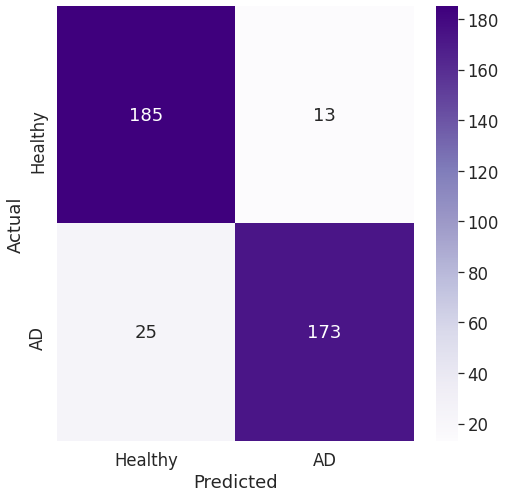

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#cm = confusion_matrix(y_test, y_pred)
# Normalise
#cmn = (Total.astype('float') / Total.sum(axis=1)[:, np.newaxis])*100
fig, ax = plt.subplots(figsize=(8,8))
sns.set(font_scale=1.5)
sns.heatmap(Total, annot=True, fmt='d',  xticklabels=['Healthy','AD'], yticklabels=['Healthy','AD'],cmap="Purples")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
c

[0.7200000286102295,
 0.8799999952316284,
 0.8399999737739563,
 0.9200000166893005,
 0.875,
 0.7083333134651184,
 0.9583333134651184,
 0.9583333134651184,
 0.9583333134651184,
 0.9583333134651184,
 0.9583333134651184]

In [ ]:
np.mean(c)

0.8849999904632568

In [ ]:
scores

[[0.6701180458068847, 0.7200000286102295],
 [0.35115572810173035, 0.8799999952316284],
 [0.4542328417301178, 0.8399999737739563],
 [0.3680244520306587, 0.9200000166893005],
 [0.25214419544984895, 0.875],
 [0.913515567779541, 0.7083333134651184],
 [0.10278299544006586, 0.9583333134651184],
 [0.2535734906171759, 0.9583333134651184],
 [0.13641733769327402, 0.9583333134651184],
 [0.16225015884265304, 0.9583333134651184],
 [0.12959324258069196, 0.9583333134651184]]

In [ ]:
#####K-fold Cross Validation#####
from sklearn.model_selection import StratifiedKFold
TEST_SPLIT=0.1

#X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=TEST_SPLIT, random_state=0, stratify=y)

kFold = StratifiedKFold(n_splits=11)
scores = []
idx = 0
for train, test in kFold.split(X, y):
  idx = idx+1
  print("fold:", idx)
  X_trr=X[train]
  y_tr=np.repeat(y[train], 89)
  X_tr=[]
  for audio in X_trr:
    audio_chunks=list(split_overlap(audio,16000,8000))
    for chunk in audio_chunks[:89]:
        X_tr.append(np.array(chunk))
  X_te=X[test]
  y_test=np.repeat(y[test], 89)
  X_test=[]
  for audio in X_te:
    audio_chunks=list(split_overlap(audio,16000,8000))
    for chunk in audio_chunks[:89]:
        X_test.append(np.array(chunk))
  #X_tr=np.array(X_tr).reshape(len(X_tr),1)
  #X_test=np.array(X_test).reshape(len(X_test),1)
  X_train, X_val, y_train, y_val= train_test_split(X_tr, y_tr, test_size=TEST_SPLIT, random_state=0, stratify=y_tr)
  y_train=to_categorical(y_train, num_classes=2)
  y_val=to_categorical(y_val, num_classes=2)
  y_test=to_categorical(y_test, num_classes=2)

  R=han_model.train_model(checkpoint_path, np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), np.array(X_test), np.array(y_test), epochs=10,batch_size=32)
  scores.append(R)
print(scores)
#print(scores.mean())

In [ ]:
#####K-fold Cross Validation#####
from sklearn.model_selection import StratifiedKFold
TEST_SPLIT=0.1

#X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=TEST_SPLIT, random_state=0, stratify=y)

kFold = StratifiedKFold(n_splits=11)
scores = []
idx = 0
for train, test in kFold.split(X, y):
  idx = idx+1
  print("fold:", idx)
  X_trr=X[train]
  y_tr=np.repeat(y[train], 45)
  X_tr=[]
  for audio in X_trr:
    audio_chunks=list(split_overlap(audio,16000,0))
    for chunk in audio_chunks[:45]:
        X_tr.append(np.array(chunk))
  X_te=X[test]
  y_test=np.repeat(y[test], 45)
  X_test=[]
  for audio in X_te:
    audio_chunks=list(split_overlap(audio,16000,0))
    for chunk in audio_chunks[:45]:
        X_test.append(np.array(chunk))
  #X_tr=np.array(X_tr).reshape(len(X_tr),1)
  #X_test=np.array(X_test).reshape(len(X_test),1)
  X_train, X_val, y_train, y_val= train_test_split(X_tr, y_tr, test_size=TEST_SPLIT, random_state=0, stratify=y_tr)
  y_train=to_categorical(y_train, num_classes=2)
  y_val=to_categorical(y_val, num_classes=2)
  y_test=to_categorical(y_test, num_classes=2)

  R=han_model.train_model(checkpoint_path, np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), np.array(X_test), np.array(y_test), epochs=10,batch_size=32)
  scores.append(R)
print(scores)
#print(scores.mean())

fold: 1
Train on 20290 samples, validate on 2255 samples
Epoch 1/10
20290/20290 [==============================] - 22s 1ms/step - loss: 0.7436 - acc: 0.5821 - val_loss: 0.7434 - val_acc: 0.5796

Epoch 00001: val_loss improved from inf to 0.74338, saving model to /content/model.01-0.74.hdf5
Epoch 2/10
20290/20290 [==============================] - 14s 714us/step - loss: 0.7026 - acc: 0.5962 - val_loss: 0.8160 - val_acc: 0.5667

Epoch 00002: val_loss did not improve from 0.74338
Epoch 3/10
20290/20290 [==============================] - 15s 715us/step - loss: 0.6841 - acc: 0.6084 - val_loss: 0.8420 - val_acc: 0.4882

Epoch 00003: val_loss did not improve from 0.74338
Epoch 4/10
20290/20290 [==============================] - 14s 712us/step - loss: 0.6729 - acc: 0.6146 - val_loss: 0.6713 - val_acc: 0.6129

Epoch 00004: val_loss improved from 0.74338 to 0.67126, saving model to /content/model.04-0.67.hdf5
Epoch 5/10
20290/20290 [==============================] - 14s 714us/step - loss: 0.6632

In [ ]:
np.savez('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/2second_disjoint.npz',result=scores)


In [ ]:
W=np.load('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/3second_disjoint.npz', allow_pickle=True)
scores=W['result']

In [ ]:
from sklearn.model_selection import StratifiedKFold
kFold = StratifiedKFold(n_splits=11)
TEST=[]
for train, test in kFold.split(X, y):
  print(len(y[test]),np.count_nonzero(y[test]))
  TEST.append(y[test])


In [ ]:
#Frame Accuracy
F=[]
for i in range(11):
  F.append(scores[i][0])
  print(scores[i][0])

In [ ]:
np.mean(F)

In [ ]:
k=9
sec=2
d=int(90/sec)
p=[]
for i in range(11):
  pp=[]
  for j in range(int(len(scores[i][1])/d)):
    if np.mean(scores[i][1][j*d:(j+1)*d])>=(0.1*k):
      ppp=1
    else:
      ppp=0
    pp.append(ppp)
  p.append(pp)

from sklearn.metrics import accuracy_score
acc9=[]
for i in range(11):
  acc9.append(accuracy_score(TEST[i], p[i]))

In [ ]:
dataset = pd.DataFrame({'Total': F,'T=0.1': acc1, 'T=0.2': acc2, 'T=0.3': acc3, 'T=0.4': acc4, 'T=0.5': acc5, 'T=0.6': acc6, 'T=0.7': acc7, 'T=0.8': acc8, 'T=0.9': acc9})

In [ ]:
dataset.to_csv('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/2second_disjoint.csv')

In [ ]:
#####K-fold Cross Validation#####
from sklearn.model_selection import StratifiedKFold
TEST_SPLIT=0.1

#X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=TEST_SPLIT, random_state=0, stratify=y)

kFold = StratifiedKFold(n_splits=11)
scores = []
idx = 0
for train, test in kFold.split(X, y):
  idx = idx+1
  print("fold:", idx)
  X_trr=X[train]
  y_tr=np.repeat(y[train], 119)
  X_tr=[]
  for audio in X_trr:
    audio_chunks=list(split_overlap(audio,16000,8000))
    for chunk in audio_chunks[:119]:
        X_tr.append(np.array(chunk))
  X_te=X[test]
  y_test=np.repeat(y[test], 119)
  X_test=[]
  for audio in X_te:
    audio_chunks=list(split_overlap(audio,16000,8000))
    for chunk in audio_chunks[:119]:
        X_test.append(np.array(chunk))
  #X_tr=np.array(X_tr).reshape(len(X_tr),1)
  #X_test=np.array(X_test).reshape(len(X_test),1)
  X_train, X_val, y_train, y_val= train_test_split(X_tr, y_tr, test_size=TEST_SPLIT, random_state=0, stratify=y_tr)
  y_train=to_categorical(y_train, num_classes=2)
  y_val=to_categorical(y_val, num_classes=2)
  y_test=to_categorical(y_test, num_classes=2)

  R=han_model.train_model(checkpoint_path, np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), np.array(X_test), np.array(y_test), epochs=10,batch_size=32)
  scores.append(R)
print(scores)
#print(scores.mean())

fold: 1


In [ ]:
RR=np.array(scores)
sss=pd.DataFrame(RR)
ssss=sss.to_csv('/content/BEST_Vggish_3stage_5sec_12_length_120_Train on 219 samples, validate on 25 samples_batchsize_20.csv')

In [ ]:
scores
#one stage whole data no attention

[[0.7161642462015152, 0.5535714360220092],
 [0.6899943511400904, 0.6250000085149493],
 [0.544226735830307, 0.6909090930765326],
 [0.5713294256817211, 0.763636361468922],
 [0.5181488205086101, 0.7636363668875261],
 [0.3657110333442688, 0.8000000065023248],
 [0.22319660877639597, 0.9454545432871039],
 [0.19283794205297122, 0.9454545324498956],
 [0.22054146060889418, 0.9636363603852012],
 [0.14177803254940294, 0.9454545432871039]]

In [ ]:
mean

0.7996753251881569

In [ ]:
scores
#one stage balanced data 99-99

[[0.7055569589138031, 0.5999999940395355],
 [0.5687799975275993, 0.75],
 [0.3192557618021965, 0.8999999761581421],
 [0.5573161244392395, 0.7999999821186066],
 [0.10721722524613142, 0.949999988079071],
 [0.33060857537202537, 0.949999988079071],
 [0.013233869569376111, 1.0],
 [0.49167499179020524, 0.9000000059604645],
 [0.16151458730823115, 0.9473684241897181],
 [0.0283720049713003, 1.0]]

In [ ]:
mean

0.879736835862461

In [ ]:
scores
#one stage whole data

[[0.7044272273778915, 0.5892857209380183],
 [0.6312395366174834, 0.7321428539497512],
 [0.4268934415145354, 0.8363636298613115],
 [0.5395892533389005, 0.763636361468922],
 [0.3502138124948198, 0.8909090865742076],
 [0.2032083191654899, 0.9272727207704023],
 [0.12245123348706825, 0.9636363549665972],
 [0.20962886834009128, 0.9454545487057079],
 [0.08856807670831172, 0.9636363603852012],
 [0.044216264452023264, 0.9818181774832986]]

In [ ]:
mean

0.8594155815103418

In [ ]:
scores
#169 AD 99 H: Train on 217 samples, validate on 25 samples

[[0.7079873636916831, 0.5925925981115412],
 [0.4135951278386293, 0.8518518496442724],
 [0.37247150308556026, 0.8888888955116272],
 [0.6628948626694856, 0.814814825852712],
 [0.39389871181575237, 0.8518518606821696],
 [0.6761943098433592, 0.88888888447373],
 [0.06428711668208793, 1.0],
 [0.1654565988962228, 0.88888888447373],
 [0.12455897463055757, 0.9615384569534888],
 [0.016483657384434573, 1.0]]

In [ ]:
mean

0.8739316255703272

In [ ]:
scores
#Maryam_HAN_AUD_Vggish_4 model with 309 AD , 243 H,  no attention in first level

[[1.1607725973482486, 0.3333333377484922],
 [0.9900024698840247, 0.7777777799853572],
 [0.684132526870127, 0.814814825852712],
 [0.5071302210843122, 0.7777777799853572],
 [0.29601521486485444, 0.88888888447373],
 [0.23662569594603997, 0.9629629651705424],
 [0.16025464222938926, 0.9259259303410848],
 [0.18824190094515128, 0.9259259193031876],
 [0.29971907287836075, 0.923076909322005],
 [0.05715672631945031, 0.9615384523685162]]

In [ ]:
mean

0.8292022784550985

In [ ]:
scores
#2 stage_HAN_AUD_Vggish model with 309 AD , 243 H,  only attention in second level

[[0.758333255137716, 0.6071428560784885],
 [0.7034249433449337, 0.7500000042574746],
 [0.5651081935925917, 0.7818181894042275],
 [0.7742116071961143, 0.8181818181818182],
 [0.1920474371449514, 0.9272727316076105],
 [0.40847147975794296, 0.8545454523780129],
 [0.21830551603555, 0.8727272532202981],
 [0.3683843456674367, 0.9454545432871039],
 [0.2794009842486544, 0.9636363603852012],
 [0.3526898547583683, 0.9454545324498956]]

In [ ]:
mean

0.8466233741250132

In [ ]:
scores
#2 stage_HAN_AUD_Vggish model with 309 AD , 243 H,  only attention without bidirectional

[[1.0389530658721924, 0.42857144081166815],
 [0.8001879043877125, 0.6428571348743779],
 [1.0766921612349423, 0.7090909047560259],
 [0.5382714677940715, 0.8000000065023248],
 [1.2156867330724543, 0.763636356050318],
 [0.7558718215335499, 0.7272727272727273],
 [0.38933771272951906, 0.9090908982537009],
 [0.6690689741041173, 0.7999999956651167],
 [0.27500474893233995, 0.9272727207704023],
 [1.0646307407243347, 0.8181818181818182]]

In [ ]:
mean

0.7525974003138479

In [ ]:
scores
#2 stage_HAN_AUD_Vggish model with 309 AD , 243 H

[[0.7367201692291668, 0.5357142801263503],
 [0.7062466485159737, 0.6428571503077235],
 [0.5848588970574465, 0.7636363668875261],
 [0.6592520367015492, 0.6909091093323447],
 [0.2859180048108101, 0.8909090811556036],
 [0.4261564693667672, 0.854545457796617],
 [0.23641812125093897, 0.9454545432871039],
 [0.21630226191270843, 0.9272727261890065],
 [0.38584923244674096, 0.9454545487057079],
 [0.08587489088743248, 0.9818181774832986]]

In [ ]:
mean
#2 stage_HAN_AUD_Vggish model with 309 AD , 243 H

0.8178571441271283

In [ ]:
scores
#99 AD 99 H: Train on 161 samples, validate on 18 sample

[[0.7978907525539398, 0.5000000149011612],
 [0.6871496438980103, 0.699999988079071],
 [0.5021384358406067, 0.75],
 [0.4272589311003685, 0.7999999821186066],
 [0.40099892020225525, 0.75],
 [0.8385019153356552, 0.7000000178813934],
 [0.3079960197210312, 0.9000000059604645],
 [0.31848144344985485, 0.949999988079071],
 [0.05703929223512348, 1.0],
 [0.06559916624897405, 0.9473684085042853]]

In [ ]:
mean
#99 AD 99 H: Train on 161 samples, validate on 18 sample

0.7997368405524053

In [ ]:
scores
#169 AD 99 H: Train on 217 samples, validate on 25 sample

[[0.8569804098871019, 0.6296296296296297],
 [0.5515558101512767, 0.7777777799853572],
 [0.38175353269886086, 0.88888888447373],
 [0.3531476724202986, 0.8518518606821696],
 [0.10667601917628888, 0.9629629541326452],
 [0.27749684342631586, 0.9259259193031876],
 [0.3157000921114727, 0.9629629541326452],
 [0.10372332987134103, 0.9629629541326452],
 [0.427217938292485, 0.9230769047370324],
 [0.7930960411635729, 0.8461538369839008]]

In [ ]:
mean
#169 AD 99 H: Train on 217 samples, validate on 25 samples

0.8732193678192942

In [ ]:
R

([0.165426356411031, 0.9454545324498956],
 0.9354838709677419,
 0.9666666666666667,
 0.9508196721311476,
 0.8896321070234113,
 0.9946666666666667,
 array([[23,  2],
        [ 1, 29]]))

In [ ]:
k=0
for i in range(11):
  k=k+RR[i][0][1]
mean=k/11


In [ ]:
mean

0.878181812618718

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT)

In [ ]:
han_model.train_model(checkpoint_path, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test),epochs=50,batch_size=20)

In [ ]:
han_model.show_sent_attention(X[0])

array([[4.49207376e-13, 7.50734544e-12, 4.93533880e-09, 2.52109976e-03,
        4.00376711e-11, 1.46210869e-03, 1.97481662e-02, 9.73984718e-01,
        2.22077570e-03, 6.31430448e-05, 2.59968083e-08, 6.71469065e-13,
        4.22983263e-13, 3.80839810e-13, 3.56785321e-13, 3.43132749e-13,
        3.35023648e-13, 3.30050494e-13, 3.27083141e-13, 3.25766351e-13,
        3.26705947e-13, 3.34051255e-13, 3.83684810e-13, 2.02814263e-12],
       [3.67372222e-02, 3.76638360e-02, 3.76354754e-02, 3.74489389e-02,
        3.72217037e-02, 3.69952135e-02, 3.67929712e-02, 3.66203189e-02,
        3.64763662e-02, 3.63571756e-02, 3.62583511e-02, 3.61752510e-02,
        3.61047350e-02, 3.60434949e-02, 3.59897092e-02, 3.59421670e-02,
        3.59014049e-02, 3.58705297e-02, 3.58593129e-02, 3.58924344e-02,
        3.60494778e-02, 3.66841480e-02, 4.07515913e-02, 1.56528205e-01],
       [5.40194868e-11, 1.34282868e-06, 3.61630367e-03, 6.98284071e-04,
        1.90377228e-10, 1.77307508e-03, 3.71982250e-03, 1.0483

In [ ]:
han_model.show_sent_attention(X[0])

array([[4.49207376e-13, 7.50734544e-12, 4.93533880e-09, 2.52109976e-03,
        4.00376711e-11, 1.46210869e-03, 1.97481662e-02, 9.73984718e-01,
        2.22077570e-03, 6.31430448e-05, 2.59968083e-08, 6.71469065e-13,
        4.22983263e-13, 3.80839810e-13, 3.56785321e-13, 3.43132749e-13,
        3.35023648e-13, 3.30050494e-13, 3.27083141e-13, 3.25766351e-13,
        3.26705947e-13, 3.34051255e-13, 3.83684810e-13, 2.02814263e-12],
       [3.67372222e-02, 3.76638360e-02, 3.76354754e-02, 3.74489389e-02,
        3.72217037e-02, 3.69952135e-02, 3.67929712e-02, 3.66203189e-02,
        3.64763662e-02, 3.63571756e-02, 3.62583511e-02, 3.61752510e-02,
        3.61047350e-02, 3.60434949e-02, 3.59897092e-02, 3.59421670e-02,
        3.59014049e-02, 3.58705297e-02, 3.58593129e-02, 3.58924344e-02,
        3.60494778e-02, 3.66841480e-02, 4.07515913e-02, 1.56528205e-01],
       [5.40194868e-11, 1.34282868e-06, 3.61630367e-03, 6.98284071e-04,
        1.90377228e-10, 1.77307508e-03, 3.71982250e-03, 1.0483

In [ ]:
doc_attention=han_model.show_doc_attention(X)

In [ ]:
sent_att=np.empty((268,5,24),dtype=None)
for i in range(len(X)):
  sent_att[i]=han_model.show_sent_attention(X[i])

In [ ]:
np.savez('/content/doc_sent_att.npz',doc=han_model.show_doc_attention(X), sent=sent_att)


In [ ]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

sample_rate, samples = wavfile.read('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/AD/001-0.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

plt.pcolormesh(times, frequencies, spectrogram)
plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import scipy.io as sio

sample_rate, samples = sio.wavfile.read('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/AD/001-0.wav')


In [ ]:
import numpy as np
X=np.load('/content/doc_sent_att.npz')


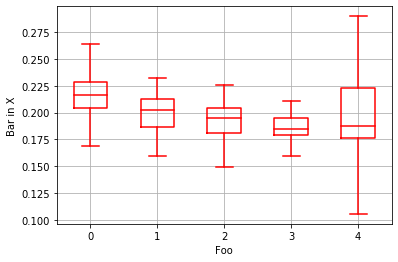

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

X=np.load('/content/doc_sent_att.npz')
#df = pd.DataFrame(np.random.rand(10, 5), columns=['A', 'B', 'C', 'D', 'E'])
df=X['doc'][:169]
df=pd.DataFrame(df)
ax = df.plot(kind='box',
             color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='-', linewidth=1.5),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=False, grid=True, rot=0)
ax.set_xlabel('Foo')
ax.set_ylabel('Bar in X')
plt.show()

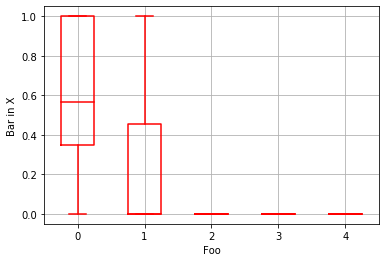

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

X=np.load('/content/doc_sent_att.npz')
#df = pd.DataFrame(np.random.rand(10, 5), columns=['A', 'B', 'C', 'D', 'E'])
df=new_matrix[:169]
df=pd.DataFrame(df)
ax = df.plot(kind='box',
             color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='-', linewidth=1.5),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=False, grid=True, rot=0)
ax.set_xlabel('Foo')
ax.set_ylabel('Bar in X')
plt.show()

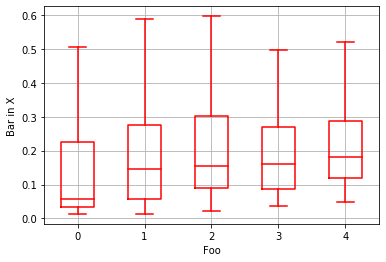

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

X=np.load('/content/doc_sent_att.npz')
#df = pd.DataFrame(np.random.rand(10, 5), columns=['A', 'B', 'C', 'D', 'E'])
df=X['doc'][169:]
df=pd.DataFrame(df)
ax = df.plot(kind='box',
             color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='-', linewidth=1.5),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=False, grid=True, rot=0)
ax.set_xlabel('Foo')
ax.set_ylabel('Bar in X')
plt.show()

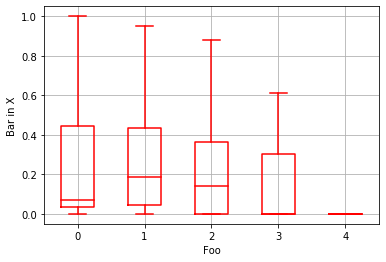

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

X=np.load('/content/doc_sent_att.npz')
#df = pd.DataFrame(np.random.rand(10, 5), columns=['A', 'B', 'C', 'D', 'E'])
df=new_matrix[169:]
df=pd.DataFrame(df)
ax = df.plot(kind='box',
             color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='-', linewidth=1.5),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=False, grid=True, rot=0)
ax.set_xlabel('Foo')
ax.set_ylabel('Bar in X')
plt.show()

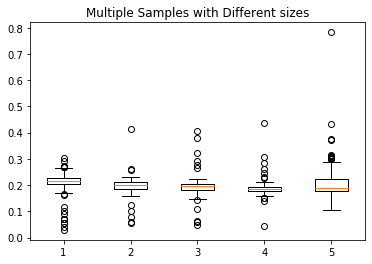

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig7, ax7 = plt.subplots()
ax7.set_title('Multiple Samples with Different sizes')
ax7.boxplot(X['doc'][:169])

plt.show()

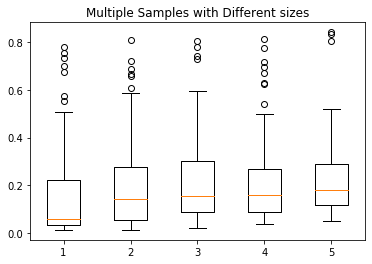

In [ ]:
fig8, ax8 = plt.subplots()
ax8.set_title('Multiple Samples with Different sizes')
ax8.boxplot(X['doc'][169:])

plt.show()

In [ ]:
X['doc'][171]

array([0.04023547, 0.03835283, 0.0595754 , 0.05484349, 0.8069928 ],
      dtype=float32)

In [ ]:
X['doc'][172]

array([0.04332411, 0.11204503, 0.2473117 , 0.29733813, 0.29998103],
      dtype=float32)

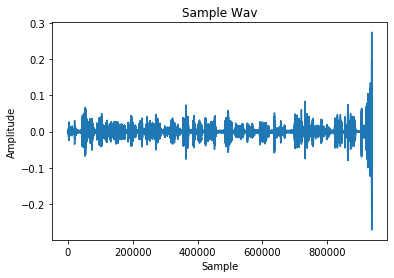

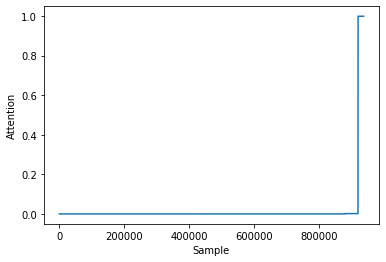

In [ ]:
import librosa
import matplotlib.pyplot as plt

y, sr = librosa.load('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/Control/015-0.wav', sr=8000, mono=True)
X=np.load('/content/doc_sent_att.npz')
#plt.subplot(210)
# plot the first 1024 samples
plt.plot(y)
# label the axes
plt.ylabel("Amplitude")
plt.xlabel("Sample")
# set the title  
plt.title("Sample Wav")
# display the plot
plt.show()


X0=X['sent'][172][0]
X0=np.repeat(X0, 40000)
plt.plot(X0[:len(y)])
plt.xlabel('Sample')
plt.ylabel('Attention')
plt.show()



In [ ]:
len(y)

897150

In [ ]:
X['sent'][172][0]

array([5.84962148e-11, 1.47700463e-09, 5.95129590e-09, 1.19744728e-10,
       9.07304987e-09, 2.11633887e-11, 1.11280674e-09, 1.89390956e-08,
       1.48987715e-11, 5.74144376e-09, 2.64352096e-10, 2.55761101e-08,
       3.26606559e-12, 1.72978076e-08, 5.03114148e-11, 4.47334281e-13,
       3.91764798e-09, 1.33787253e-04, 3.29960073e-07, 1.65447118e-11,
       9.86275436e-11, 3.25091569e-05, 1.58800406e-03, 9.98245239e-01])

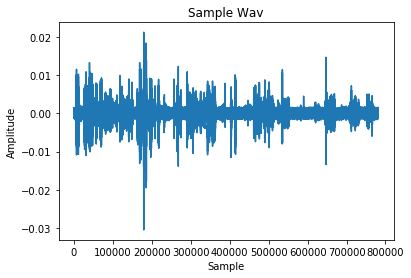

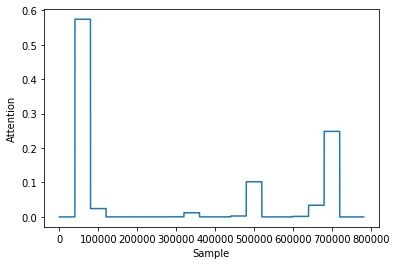

In [ ]:
import librosa
y, sr = librosa.load('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/Control/015-1.wav', sr=8000, mono=True)
X=np.load('/content/doc_sent_att.npz')
#plt.subplot(210)
# plot the first 1024 samples
plt.plot(y)
# label the axes
plt.ylabel("Amplitude")
plt.xlabel("Sample")
# set the title  
plt.title("Sample Wav")
# display the plot
plt.show()


X0=X['sent'][172][1]
X0=np.repeat(X0, 40000)
plt.plot(X0[:len(y)])
plt.xlabel('Sample')
plt.ylabel('Attention')
plt.show()



In [ ]:
X['sent'][172][1]


array([1.44212681e-05, 5.74192703e-01, 2.42414679e-02, 6.09092203e-05,
       3.72848660e-07, 1.02576564e-06, 1.71952110e-04, 2.80807464e-04,
       1.20772468e-02, 1.58513663e-04, 9.39688252e-05, 2.66543031e-03,
       1.02110416e-01, 6.03110834e-07, 6.51759619e-05, 1.54689455e-03,
       3.38908844e-02, 2.48387739e-01, 9.91385150e-06, 7.82845382e-06,
       2.66754313e-07, 3.55369900e-10, 1.19463939e-09, 2.14364572e-05])

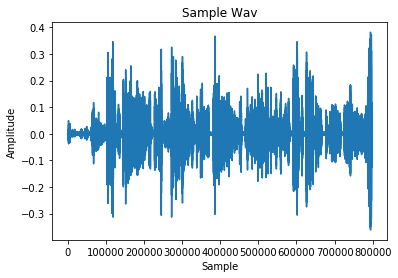

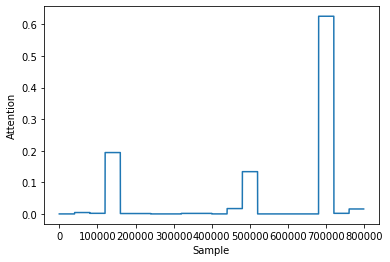

In [ ]:
import librosa
y, sr = librosa.load('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/Control/015-2.wav', sr=8000, mono=True)
X=np.load('/content/doc_sent_att.npz')
#plt.subplot(210)
# plot the first 1024 samples
plt.plot(y)
# label the axes
plt.ylabel("Amplitude")
plt.xlabel("Sample")
# set the title  
plt.title("Sample Wav")
# display the plot
plt.show()


X0=X['sent'][172][2]
X0=np.repeat(X0, 40000)
plt.plot(X0[:len(y)])
plt.xlabel('Sample')
plt.ylabel('Attention')
plt.show()



In [ ]:
X['sent'][172][2]

array([2.73926766e-08, 4.35712608e-03, 1.89240533e-03, 1.94188058e-01,
       1.20374560e-03, 1.17602805e-03, 9.78744481e-08, 7.40824316e-06,
       1.61402184e-03, 1.62562623e-03, 4.58414579e-05, 1.69063658e-02,
       1.33745059e-01, 1.20269551e-05, 7.18259253e-05, 6.69717215e-09,
       4.20161435e-08, 6.25647068e-01, 1.87428831e-03, 1.56327989e-02,
       6.57432082e-08, 2.13562449e-11, 4.54918672e-11, 2.89231075e-08])

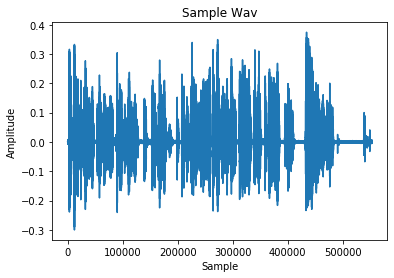

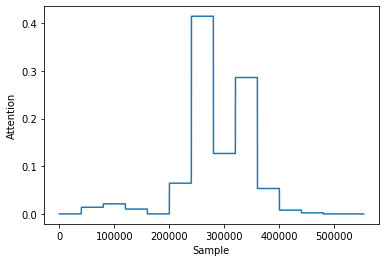

In [ ]:
import librosa
y, sr = librosa.load('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/Control/015-3.wav', sr=8000, mono=True)
X=np.load('/content/doc_sent_att.npz')
#plt.subplot(210)
# plot the first 1024 samples
plt.plot(y)
# label the axes
plt.ylabel("Amplitude")
plt.xlabel("Sample")
# set the title  
plt.title("Sample Wav")
# display the plot
plt.show()


X0=X['sent'][172][3]
X0=np.repeat(X0, 40000)
plt.plot(X0[:len(y)])
plt.xlabel('Sample')
plt.ylabel('Attention')
plt.show()



In [ ]:
X['sent'][172][3]

array([4.01353282e-06, 1.39412703e-02, 2.10743323e-02, 1.01814680e-02,
       1.73525063e-06, 6.44240826e-02, 4.14348304e-01, 1.26671940e-01,
       2.85941333e-01, 5.32459840e-02, 7.90511351e-03, 2.26032361e-03,
       3.83298220e-11, 1.07295193e-07, 6.16489748e-09, 4.42085322e-17,
       1.20039689e-17, 6.52970668e-18, 4.90653844e-18, 4.29594845e-18,
       4.10156886e-18, 4.30296790e-18, 6.41497466e-18, 3.36545513e-16])

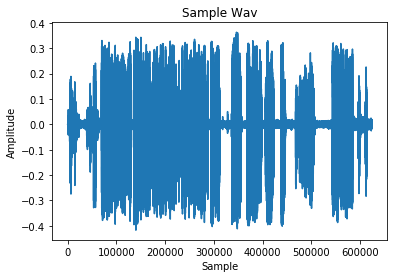

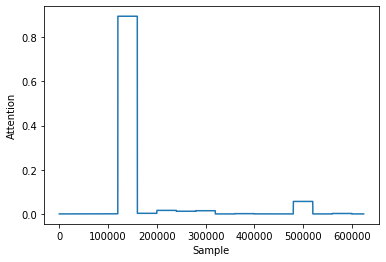

In [ ]:
import librosa
y, sr = librosa.load('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/Control/015-4.wav', sr=8000, mono=True)
X=np.load('/content/doc_sent_att.npz')
#plt.subplot(210)
# plot the first 1024 samples
plt.plot(y)
# label the axes
plt.ylabel("Amplitude")
plt.xlabel("Sample")
# set the title  
plt.title("Sample Wav")
# display the plot
plt.show()


X0=X['sent'][172][4]
X0=np.repeat(X0, 40000)
plt.plot(X0[:len(y)])
plt.xlabel('Sample')
plt.ylabel('Attention')
plt.show()



In [ ]:
X['sent'][172][4]

array([1.42162480e-06, 6.74698822e-06, 5.02915820e-04, 8.94504130e-01,
       2.71543977e-03, 1.59768406e-02, 1.21125244e-02, 1.45026557e-02,
       6.66539740e-11, 1.12441927e-03, 1.62166340e-04, 4.00547009e-07,
       5.64739369e-02, 5.80311678e-07, 1.91528082e-03, 5.05769378e-07,
       9.80392525e-14, 2.63983705e-15, 7.01218343e-16, 4.05908379e-16,
       3.31163889e-16, 3.37207628e-16, 5.75898495e-16, 8.06305774e-14])

[Text(0, 0.5, 'Y Values'), Text(0.5, 0, 'X Values')]

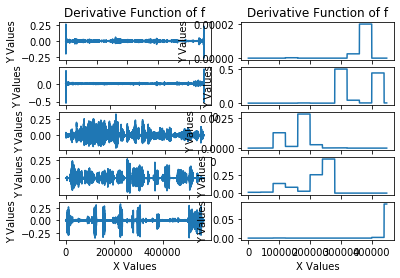

In [ ]:
import librosa
y0, sr = librosa.load('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/AD/010-0.wav', sr=8000, mono=True)
f, ax = plt.subplots(5, 2)
                            
ax[0,0].plot(y0)
# label the axes
ax[0,0].set(xlabel='X Values', ylabel='Y Values',
       title='Derivative Function of f')

y1, sr = librosa.load('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/AD/010-1.wav', sr=8000, mono=True)                          
ax[1,0].plot(y1)
# label the axes
ax[1,0].set(xlabel='X Values', ylabel='Y Values'
       )


y2, sr = librosa.load('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/AD/010-2.wav', sr=8000, mono=True)                            
ax[2,0].plot(y2)
# label the axes
ax[2,0].set(xlabel='X Values', ylabel='Y Values'
       )


y3, sr = librosa.load('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/AD/010-3.wav', sr=8000, mono=True)
ax[3,0].plot(y3)
# label the axes
ax[3,0].set(xlabel='X Values', ylabel='Y Values'
       )


y4, sr = librosa.load('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/AD/010-4.wav', sr=8000, mono=True)
ax[4,0].plot(y4)
# label the axes
ax[4,0].set(xlabel='X Values', ylabel='Y Values'
       )


k=0
X0=X['sent'][4][k]
X0=np.repeat(X0, 40000)
ax[k,1].plot(X0[:len(y)])
ax[k,1].set(xlabel='X Values', ylabel='Y Values',
       title='Derivative Function of f')

k=1
X0=X['sent'][4][k]
X0=np.repeat(X0, 40000)
ax[k,1].plot(X0[:len(y)])
ax[k,1].set(xlabel='X Values', ylabel='Y Values'
       )

k=2
X0=X['sent'][4][k]
X0=np.repeat(X0, 40000)
ax[k,1].plot(X0[:len(y)])
ax[k,1].set(xlabel='X Values', ylabel='Y Values'
       )

k=3
X0=X['sent'][4][k]
X0=np.repeat(X0, 40000)
ax[k,1].plot(X0[:len(y)])
ax[k,1].set(xlabel='X Values', ylabel='Y Values'
       )

k=4
X0=X['sent'][4][k]
X0=np.repeat(X0, 40000)
ax[k,1].plot(X0[:len(y)])
ax[k,1].set(xlabel='X Values', ylabel='Y Values'
       )


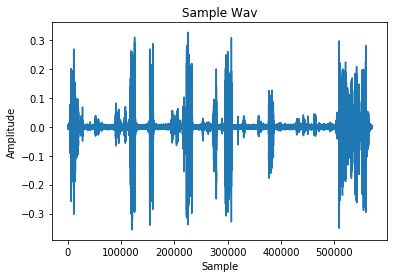

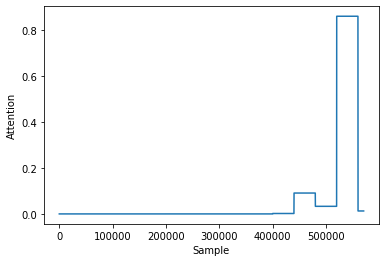

In [ ]:
len(y)

448680

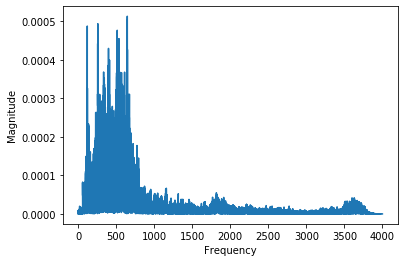

In [ ]:
plt.magnitude_spectrum(y[:320000], Fs=8000)
plt.xlabel('Frequency')

plt.ylabel('Magnitude')

plt.show()

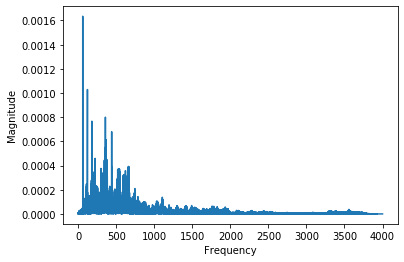

In [ ]:
import librosa
y, sr = librosa.load('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/AD/033-0.wav', sr=8000, mono=True)

plt.magnitude_spectrum(y, Fs=8000)
plt.xlabel('Frequency')

plt.ylabel('Magnitude')

plt.show()

area = 257.137735583407


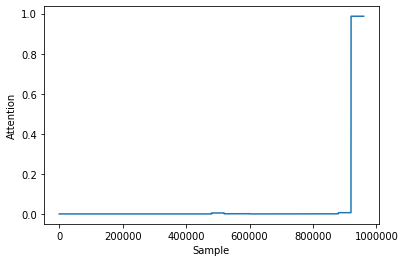

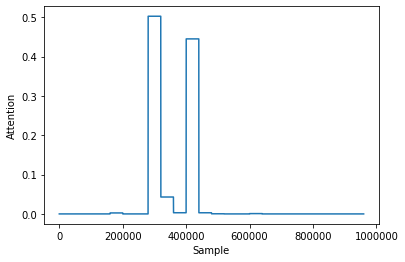

area = 40000.00020132209


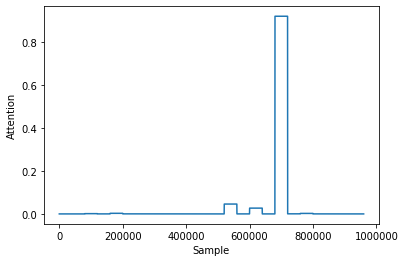

area = 39993.01960648915


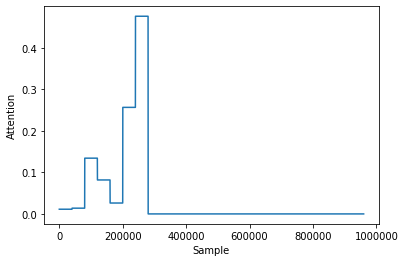

area = 39999.992112537024


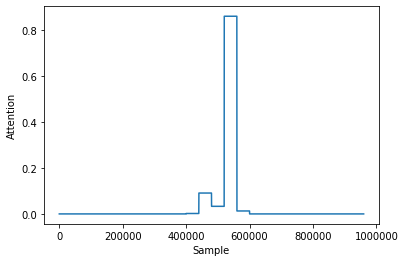

area = 40000.00292626922


In [ ]:
k=4
from numpy import trapz

X0=X['sent'][k][0]
X0=np.repeat(X0, 40000)
area = trapz(X0[:800000],dx=1)
print("area =", area)
plt.plot(X0)
plt.xlabel('Sample')

plt.ylabel('Attention')

plt.show()


X0=X['sent'][k][1]
X0=np.repeat(X0, 40000)
plt.plot(X0)
plt.xlabel('Sample')

plt.ylabel('Attention')

plt.show()
area = trapz(X0[:800000])
print("area =", area)

X0=X['sent'][k][2]
X0=np.repeat(X0, 40000)
plt.plot(X0)
plt.xlabel('Sample')

plt.ylabel('Attention')

plt.show()
area = trapz(X0[:800000])
print("area =", area)


X0=X['sent'][k][3]
X0=np.repeat(X0, 40000)
plt.plot(X0)
plt.xlabel('Sample')

plt.ylabel('Attention')

plt.show()
area = trapz(X0[:800000])
print("area =", area)

X0=X['sent'][k][4]
X0=np.repeat(X0, 40000)
plt.plot(X0)
plt.xlabel('Sample')

plt.ylabel('Attention')

plt.show()
area = trapz(X0[:800000])
print("area =", area)

In [ ]:
X['doc'][:20]

array([[0.18784593, 0.17908777, 0.2662115 , 0.17912094, 0.18773387],
       [0.21112438, 0.20794992, 0.1930377 , 0.18139492, 0.20649311],
       [0.21692154, 0.22301906, 0.19009633, 0.19890419, 0.1710589 ],
       [0.23661347, 0.20515099, 0.21254192, 0.17164329, 0.17405032],
       [0.16516426, 0.18370843, 0.21049051, 0.22595495, 0.21468186],
       [0.26395115, 0.26160523, 0.16041704, 0.1593824 , 0.15464419],
       [0.0293961 , 0.22969599, 0.04691314, 0.26290432, 0.43109044],
       [0.21072389, 0.21060456, 0.19601971, 0.18279235, 0.19985944],
       [0.22727379, 0.23046668, 0.18505184, 0.18796484, 0.16924289],
       [0.23390025, 0.20436266, 0.18717706, 0.19803458, 0.17652543],
       [0.2610664 , 0.18601348, 0.19301578, 0.17508082, 0.18482348],
       [0.21730049, 0.18530776, 0.20731299, 0.18936105, 0.20071767],
       [0.06924348, 0.12458949, 0.22528063, 0.28286836, 0.29801798],
       [0.21647234, 0.19533613, 0.21720347, 0.19683968, 0.17414846],
       [0.22201268, 0.21820949, 0.

In [ ]:
X0=X['sent'][k][0]

In [ ]:
X0

array([6.33832526e-12, 7.09371625e-06, 1.94902113e-05, 1.02783503e-07,
       1.47518091e-04, 1.76259282e-03, 1.51163121e-07, 3.68816708e-03,
       1.40062213e-01, 1.50751192e-02, 8.39196801e-01, 4.07502230e-05,
       1.73024369e-14, 1.55985691e-14, 1.44130601e-14, 1.36528065e-14,
       1.31704086e-14, 1.28640901e-14, 1.26770729e-14, 1.25874432e-14,
       1.26238690e-14, 1.30011875e-14, 1.56218219e-14, 1.30851561e-13])

In [ ]:
X0=np.repeat(X0[:12], 40000)

In [ ]:
len(X0)

480000

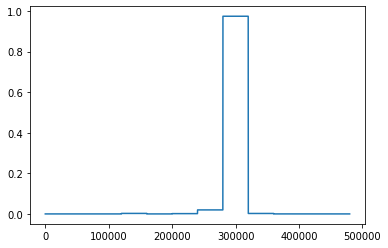

In [ ]:
plt.plot(X0)
plt.show()

In [ ]:
sent['y'].shape

(268, 5, 24)

In [ ]:
import pandas as pd
sent_att=pd.DataFrame(sent_att)
doc_att=pd.DataFrame(han_model.show_doc_attention(X))

sent_att.to_csv('/content/sent_att.csv')
doc_att.to_csv('/content/doc_att.csv')


In [ ]:
han_model.show_doc_attention(X)

array([[4.28344786e-01, 9.97687000e-09, 5.71655214e-01, 1.18803669e-08,
        1.16093650e-08],
       [9.99832153e-01, 3.96743490e-05, 3.72490686e-05, 4.20096185e-05,
        4.88153164e-05],
       [1.66532373e-05, 1.54510388e-07, 9.99982715e-01, 1.85681444e-07,
        1.88643455e-07],
       ...,
       [1.00000000e+00, 3.09147707e-11, 1.91529206e-11, 2.01582605e-11,
        2.17221519e-11],
       [1.00000000e+00, 6.53517657e-11, 1.38674046e-11, 1.44218266e-11,
        1.55135852e-11],
       [5.51880767e-05, 1.06056419e-09, 9.99944806e-01, 2.11388147e-11,
        1.43421395e-11]], dtype=float32)

In [ ]:
X[5,2]

In [ ]:
han_model.show_sent_attention(X[0])[2]

array([0.919394  , 0.05504532, 0.0050072 , 0.00320946, 0.00231385,
       0.00243928, 0.00235019, 0.0022221 , 0.00197761, 0.00196938,
       0.00200235, 0.00206926], dtype=float32)

In [ ]:
han_model.show_doc_attention(X)[0]

array([0.24371406, 0.17326117, 0.4336014 , 0.07949234, 0.06993096],
      dtype=float32)

In [ ]:
han_model.predict

**Cross Validation**

In [ ]:
from sklearn.model_selection import StratifiedKFold
def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

Y_C=np.ones(99)
Y_D=np.zeros(99)
Y=np.concatenate((Y_D,Y_C))
skf = StratifiedKFold(11)
acc= []
i=0
for train, test in skf.split(X,Y):
        i=i+1
        xt, xv, yt, yv = X[train, :], X[test, :], Y[train], Y[test]
        yt=to_categorical(yt, num_classes=2)
        yv=to_categorical(yv, num_classes=2)
        checkpoint_path='/content/model.{epoch:02d}-{val_loss:.2f}.hdf5'
        han_model.train_model(checkpoint_path, np.array(xt), np.array(yt), np.array(xv), np.array(yv),epochs=10,batch_size=20)
        # load weights
        han_model.load_weights(newest('/content/'))
        # Compile model (required to make predictions)
        han_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        yhat=han_model.predict(xv)
        accuracy=accuracy_score(list(map(lambda x: np.argmax(x), yv)), list(map(lambda x: np.argmax(x), yhat)))
        print('accuracy=',accuracy)
        acc.append(accuracy)
        del history

**Vggish Embedding Classification with DNN**

**Simple DNN**

In [ ]:
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
import keras.backend as K
from keras import regularizers
from keras.layers import Lambda
from sklearn.model_selection import train_test_split
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Activation, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers import TimeDistributed, Flatten, LSTM, GRU, Bidirectional
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import ModelCheckpoint
import numpy as np
import pickle
import os
from glob import iglob
import glob
import re


k=120
def m5(num_classes=2):
    print('Using Model M5')
    m = Sequential()
    m.add(Dense(100,input_shape=[k,128]))
    #m.add(LSTM(units=128,return_sequences=True,input_shape=[k,128]))
    #m.add(LSTM(units=128,input_shape=[k,128]))
    #m.add(LSTM(units=64))
    m.add(Flatten())
    m.add(Dense(num_classes, activation='softmax'))
    return m



**Bidirectional LSTM**

In [ ]:
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
import keras.backend as K
from keras import regularizers
from keras.layers import Lambda
from sklearn.model_selection import train_test_split
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Activation, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers import TimeDistributed, Flatten, LSTM, GRU, Bidirectional
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import ModelCheckpoint
import numpy as np
import pickle
import os
from glob import iglob
import glob
import re


k=120
def m5(num_classes=2):
    print('Using Model M5')
    m = Sequential()
    m.add(Bidirectional(LSTM (units=128),input_shape=(k,128)))
    #m.add(LSTM(units=128,input_shape=[k,128]))
    #m.add(LSTM(units=64))
    #m.add(Flatten())
    m.add(Dense(num_classes, activation='softmax'))
    return m



Using TensorFlow backend.


**Attention- BLSTM**

In [ ]:
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim



In [ ]:
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
import keras.backend as K
from keras import regularizers
from keras.layers import Lambda
from sklearn.model_selection import train_test_split
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Activation, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers import TimeDistributed, Flatten, LSTM, GRU, Bidirectional,  Dropout
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import ModelCheckpoint
import numpy as np
import pickle
import os
from glob import iglob
import glob
import re


k=120
def m5(num_classes=2):
    print('Using Model M5')
    m = Sequential()
    m.add(Bidirectional(LSTM(64, return_sequences=True),input_shape=(k,128)))
    m.add(Bidirectional(LSTM(32, return_sequences=True)))
    m.add(Attention(120))
    #x = Dense(256, activation="relu")(x)
    m.add(Dropout(0.25))
    m.add(Dense(2, activation="softmax"))
    return m


In [ ]:
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
import keras.backend as K
from keras import regularizers
from keras.layers import Lambda
from sklearn.model_selection import train_test_split
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Activation, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers import TimeDistributed, Flatten, LSTM, GRU, Bidirectional,  Dropout
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import ModelCheckpoint
import numpy as np
import pickle
import os
from glob import iglob
import glob
import re
from han.attention import Attention


k=120
def m5(num_classes=2):
    print('Using Model M5')
    m = Sequential()
    m.add(TimeDistributed(Bidirectional(LSTM(64, return_sequences=True)),input_shape=(12,10,128)))
    #m.add(Bidirectional(LSTM(32, return_sequences=True)))
    doc_att = Attention(name='sent_attention')(dense_text)
    m.add(Attention(120))
    #x = Dense(256, activation="relu")(x)
    m.add(Dropout(0.25))
    m.add(Dense(2, activation="softmax"))
    return m


In [ ]:
model = m5(num_classes=2)
#model.build(input_shape=[30,128])

print(model.summary())

Using Model M5


NameError: ignored

In [ ]:
###for reshaping X to 10 sec epochs


from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
import keras.backend as K
from keras import regularizers
from keras.layers import Lambda
from sklearn.model_selection import train_test_split
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Activation, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers import TimeDistributed, Flatten, LSTM, GRU, Bidirectional,  Dropout, Input
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import ModelCheckpoint
from keras.models import Model
import numpy as np
import pickle
import os
from glob import iglob
import glob
import re
from han.attention import Attention

text_input = Input(shape=(12, 10,128), dtype='float32')
        #masked2=Masking(mask_value=Special_value)(text_input)
        # encode sentences into a single vector per sentence
        #self.model_word = self.build_word_encoder()
        # time distribute word model to accept text input
sent_encoder = TimeDistributed(Dense(128))(text_input)
x1=TimeDistributed(Bidirectional(LSTM(64, return_sequences=True)))(sent_encoder)
dense_text=TimeDistributed(Dense(128))(x1)
#doc_att = Attention()(dense_text)
#x18=(Attention(120))(x1)
model = Model(inputs=text_input, outputs=dense_text)
print(model.summary())




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 12, 10, 128)       0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 12, 10, 128)       16512     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 12, 10, 128)       98816     
_________________________________________________________________
time_distributed_9 (TimeDist (None, 12, 10, 128)       16512     
Total params: 131,840
Trainable params: 131,840
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
import keras.backend as K
from keras import regularizers
from keras.layers import Lambda
from sklearn.model_selection import train_test_split
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Activation, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers import TimeDistributed, Flatten, LSTM, GRU, Bidirectional,  Dropout
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import ModelCheckpoint
import numpy as np
import pickle
import os
from glob import iglob
import glob
import re

# This returns a tensor
text_input = Input(shape=(None, 10,128), dtype='float32')
        #masked2=Masking(mask_value=Special_value)(text_input)
        # encode sentences into a single vector per sentence
        #self.model_word = self.build_word_encoder()
        # time distribute word model to accept text input
        #sent_encoder = TimeDistributed(self.model_word)(text_input)
x1=TimeDistributed(Conv1D(128,
                 #input_shape=[AUDIO_LENGTH, 1],
                 kernel_size=80,
                 strides=4,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=regularizers.l2(l=0.0001)))(text_input)
x2=TimeDistributed(BatchNormalization())(x1)
x3=TimeDistributed(Activation('relu'))(x2)
x4=TimeDistributed(MaxPooling1D(pool_size=2, strides=None))(x3)
x17=TimeDistributed(Lambda(lambda x: K.mean(x, axis=1)))(x4)
x18=TimeDistributed(Flatten())(x17)
model = Model(inputs=text_input, outputs=x18)
print(model.summary())

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, 10, 128)     0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, None, 3, 128)      1310848   
_________________________________________________________________
time_distributed_11 (TimeDis (None, None, 3, 128)      512       
_________________________________________________________________
time_distributed_12 (TimeDis (None, None, 3, 128)      0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, None, 1, 128)      0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, None, 128)         0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, None, 128)         0  

In [ ]:
model = m5(num_classes=2)
#model.build(input_shape=[30,128])

print(model.summary())

Using Model M5


ValueError: ignored

In [ ]:
from sklearn.model_selection import StratifiedKFold
if __name__ == '__main__':
    
    num_classes = 2
    #crf = CRF(num_classes)
    model = m5(num_classes=num_classes)

    if model is None:
        exit('Something went wrong!!')

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    #model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])
    print(model.summary())

    filepath="weights.best.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    #OUTPUT_DIR_AD = '/content/drive/My Drive/Dementia_Audio/Audio_Dementia/AD'
    #OUTPUT_DIR_Control = '/content/drive/My Drive/Dementia_Audio/Audio_Dementia/Control'

    AD_files = glob.glob('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/AD/*.npz')
    Control_files=glob.glob('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/Control/*.npz')
    
    
    x_AD = create_tensor(AD_files,k)
    y_AD=np.ones(309)
    #y_AD=np.ones((99,9))
    y_AD = to_categorical(y_AD, num_classes=num_classes)
    
    x_Control = create_tensor(Control_files,k)
    y_Control=np.zeros(243)
    #y_Control=np.zeros((99,9))
    y_Control = to_categorical(y_Control, num_classes=num_classes)
    
    x_total=np.concatenate((x_AD,x_Control))  
    y_total=np.concatenate((y_AD,y_Control))

    filepath='/content/model.{epoch:02d}-{val_loss:.2f}.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    TEST_SPLIT = 0.1


    #Do cross validation on both DNN and SVM
    x_tr, x_te, y_tr, y_te= train_test_split(x_total, y_total, test_size=TEST_SPLIT, random_state=0, stratify=y_total)

    

    # if the accuracy does not increase over 10 epochs, reduce the learning rate by half.
    #reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=10, min_lr=0.0001, verbose=1)
    #batch_size = 10
    
    #n_steps, n_length = 9, 80000
   # x_tr=np.concatenate((x_AD[:89], x_Control[:89]))
    #x_te=np.concatenate((x_AD[89:99], x_Control[89:99]))
    #x_tr =x_tr.reshape((178, n_steps, n_length,1))
    #x_te = x_te.reshape((20, n_steps, n_length,1))
    #y_tr=np.concatenate((y_AD[:89], y_Control[:89]))
    #y_te=np.concatenate((y_AD[89:99], y_Control[89:99]))
    #y_tr=np.array(list(map(lambda el:[el]*9, y_tr)))
    #y_te=np.array(list(map(lambda el:[el]*9, y_te)))
    


    print('x_tr.shape =', x_tr.shape)
    print('y_tr.shape =', y_tr.shape)
    print('x_te.shape =', x_te.shape)
    print('y_te.shape =', y_te.shape)

    history = model.fit(x_tr, y_tr, batch_size=20, epochs=10,
                    validation_split=0.1, verbose=1,callbacks=callbacks_list,shuffle=False)
    
    def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

    model.load_weights(newest('/content/'))
        # Compile model (required to make predictions)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    yhat=model.predict(x_te)
    accuracy=accuracy_score(list(map(lambda x: np.argmax(x), y_te)), list(map(lambda x: np.argmax(x), yhat)))

IndentationError: ignored

**K-Fold cross validation**

In [ ]:
def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

if __name__ == '__main__':
    
    num_classes = 2
    #crf = CRF(num_classes)
    model = m5(num_classes=num_classes)

    if model is None:
        exit('Something went wrong!!')

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    #model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])
    print(model.summary())
    

    #OUTPUT_DIR_AD = '/content/drive/My Drive/Dementia_Audio/Audio_Dementia/AD'
    #OUTPUT_DIR_Control = '/content/drive/My Drive/Dementia_Audio/Audio_Dementia/Control'

    AD_files = glob.glob('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/AD/*.npz')
    Control_files=glob.glob('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/Control/*.npz')
    
    
    x_AD = create_tensor(AD_files,k)   
    y_AD=np.ones(309)
    #y_AD=np.ones((99,9))
    y_AD = to_categorical(y_AD, num_classes=num_classes)
    
    x_Control = create_tensor(Control_files,k)
    y_Control=np.zeros(243)
    #y_Control=np.zeros((99,9))
    y_Control = to_categorical(y_Control, num_classes=num_classes)
    
    X=np.concatenate((x_AD,x_Control))  
    #Y=np.concatenate((y_AD,y_Control))
    Y_D=np.ones(309)
    Y_C=np.zeros(243)
    Y=np.concatenate((Y_D,Y_C))
    skf = StratifiedKFold(2)
    acc= []
    i=0
    for train, test in skf.split(X,Y):
        i=i+1
        xt, xv, yt, yv = X[train, :], X[test, :], Y[train], Y[test]
        yt=to_categorical(yt, num_classes=2)
        yv=to_categorical(yv, num_classes=2)
        filepath='/content/model.{epoch:02d}-{val_loss:.2f}.hdf5'
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        callbacks_list = [checkpoint]
        history=model.fit(xt, yt, batch_size=32, epochs=30,
                    validation_split=0.1, verbose=1,callbacks=callbacks_list,shuffle=False)
        
        # load weights
        model.load_weights(newest('/content/'))
        # Compile model (required to make predictions)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        yhat=model.predict(xv)
        results=model.evaluate(xv, yv, batch_size=32)
        print('test loss, test acc:', results)
        #accuracy=accuracy_score(list(map(lambda x: np.argmax(x), yv)), list(map(lambda x: np.argmax(x), yhat)))
        #print(accuracy)
        acc.append(results)
        del history

Using Model M5
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 120, 128)          98816     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 120, 64)           41216     
_________________________________________________________________
attention_1 (Attention)      (None, 64)                184       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 140,346
Trainable params: 140,346
Non-trainable params: 0
_________________________________________________________________
None
Train on 248 samples, validate on 28 samples
Epoch 1/30
248/248 [=============================

KeyboardInterrupt: ignored

In [ ]:
yhat=model.predict(xv)

In [ ]:
pppp=[0,0,1,1]

In [ ]:
p=to_categorical(pppp)

In [ ]:
p[:,1]

array([0., 0., 1., 1.], dtype=float32)

In [ ]:
yhat

array([[0.37347397, 0.62652606],
       [0.48197562, 0.5180244 ],
       [0.26783478, 0.7321652 ],
       [0.4985214 , 0.5014786 ],
       [0.4857547 , 0.51424533],
       [0.05049588, 0.94950414],
       [0.33693057, 0.6630694 ],
       [0.45684564, 0.54315436],
       [0.3781664 , 0.6218336 ],
       [0.55787224, 0.44212773],
       [0.38605353, 0.6139465 ],
       [0.06913956, 0.93086046],
       [0.40657118, 0.59342873],
       [0.07339969, 0.9266003 ],
       [0.21938664, 0.78061336],
       [0.08476057, 0.91523945],
       [0.4416519 , 0.55834806],
       [0.08527716, 0.91472286],
       [0.24207133, 0.7579287 ],
       [0.05799916, 0.94200087],
       [0.5159789 , 0.48402107],
       [0.4848064 , 0.5151937 ],
       [0.34193176, 0.65806824],
       [0.19561258, 0.8043874 ],
       [0.3821834 , 0.6178166 ],
       [0.31677258, 0.6832275 ],
       [0.5768395 , 0.4231605 ],
       [0.2623337 , 0.7376663 ],
       [0.11017307, 0.8898269 ],
       [0.38942057, 0.61057943],
       [0.

In [ ]:
yhat_classes=list(map(lambda x: np.argmax(x), yhat))

In [ ]:
yhat_probs = yhat[:, 1]

In [ ]:
yhat_probs

In [ ]:
acc

[[0.7987998468535287, 0.5000000085149493],
 [0.6986056353364672, 0.5714285799435207],
 [0.4704401438886469, 0.7272727213122628],
 [0.5113964958624406, 0.7090909090909091],
 [0.39613733291625974, 0.763636361468922],
 [0.354986893046986, 0.7818181709809737],
 [0.23516252095049078, 0.8181818116794933],
 [0.19099983085285532, 0.9454545335336165],
 [0.7978284380652688, 0.6909090898253701],
 [1.3030447786504573, 0.6363636333834041]]

In [ ]:
acc
#Attention BiLSTM with 99-99: 64-32 BLSTM

[0.5555555555555556,
 0.5,
 0.6111111111111112,
 0.6111111111111112,
 0.7777777777777778,
 0.8333333333333334,
 0.6111111111111112,
 0.5555555555555556,
 0.8333333333333334,
 0.7777777777777778,
 0.8333333333333334]

In [ ]:
np.mean(acc)

0.6818181818181818

In [ ]:
acc

[0.5,
 0.6111111111111112,
 0.7222222222222222,
 0.8333333333333334,
 0.9444444444444444,
 0.9444444444444444,
 1.0,
 1.0,
 1.0,
 0.7222222222222222,
 0.6111111111111112]

In [ ]:
np.mean(acc)

0.808080808080808

In [ ]:
acc

[0.5294117647058824,
 0.7450980392156863,
 0.9,
 0.96,
 0.44,
 0.86,
 0.9,
 1.0,
 0.9,
 0.72,
 0.72]

In [ ]:
np.mean(acc)

0.7885918003565062

In [ ]:
acc

[0.49019607843137253,
 0.6274509803921569,
 0.66,
 0.76,
 0.98,
 0.94,
 0.88,
 1.0,
 0.88,
 0.76,
 0.72]

In [ ]:
np.mean(acc)

0.7906951871657754

In [ ]:
len(x_AD)

309

In [ ]:
len(X)

552

In [ ]:
len(Y)

552

In [ ]:
acc

[0.6111111111111112,
 0.7222222222222222,
 0.8333333333333334,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9444444444444444,
 0.8888888888888888,
 0.7222222222222222]

In [ ]:
np.mean(acc)

0.8838383838383838

In [ ]:
acc

[0.44642857142857145,
 0.44642857142857145,
 0.43636363636363634,
 0.45454545454545453,
 0.43636363636363634,
 0.43636363636363634,
 0.43636363636363634,
 0.43636363636363634,
 0.43636363636363634,
 0.45454545454545453]

In [ ]:
acc

[0.5,
 0.5555555555555556,
 0.6111111111111112,
 0.5,
 0.7777777777777778,
 0.6666666666666666,
 0.8333333333333334,
 0.7777777777777778,
 0.6111111111111112,
 0.5,
 0.7777777777777778]

In [ ]:
np.mean(acc)

0.6464646464646465

In [ ]:
acc

[0.5555555555555556,
 0.8888888888888888,
 0.8888888888888888,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8333333333333334,
 0.7222222222222222]

**SVM Cross Validation**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
#from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
#results, precision, recall, f1, kappa, auc, matrix
#X=x_total.reshape(len(X),-1)
X=X.reshape(len(X),-1)
Y_D=np.ones(len(XA))
Y_C=np.zeros(len(XC))
Y=np.concatenate((Y_D,Y_C))
skf = StratifiedKFold(11)
#clf=SklearnClassifier(SVC(kernel='linear',probability=True))
clf = LinearSVC(random_state=1, tol=1e-5)
R = []
for train, test in skf.split(X,Y):
        xt, xv, yt, yv = X[train, :], X[test, :], Y[train], Y[test]
        clf.fit(xt, yt)
        yhat = clf.predict(xv)
        #proba = clf.predict_proba(xv)
        acc=np.mean(yhat == yv)
        #acc.append(np.mean(yhat == yv))
        #f=metrics.classification_report(yv, yhat)
        #print(f)
        #auc.append(f)
        r0=metrics.accuracy_score(yv, yhat)
        r1=metrics.precision_score(yv, yhat)
        r2=metrics.recall_score(yv, yhat)
        r3=metrics.f1_score(yv, yhat)
        r4=metrics.cohen_kappa_score(yv, yhat)
        r5=metrics.roc_auc_score(yv, yhat)
        r6=metrics.confusion_matrix(yv, yhat)
        s=r0,r1,r2,r3,r4,r5,r6
        R.append(s)
        #precision = precision_score(y_test[:,1], yhat_classes)
        #print('Precision: %f' % precision)
        # recall: tp / (tp + fn)
        #recall = recall_score(y_test[:,1], yhat_classes)
        #print('Recall: %f' % recall)
        # f1: 2 tp / (2 tp + fp + fn)
        #f1 = f1_score(y_test[:,1], yhat_classes)
        #print('F1 score: %f' % f1)
 
        # kappa
        #kappa = cohen_kappa_score(y_test[:,1], yhat_classes)
        #print('Cohens kappa: %f' % kappa)
        # ROC AUC
        #auc = roc_auc_score(y_test[:,1], yhat_probs)
        #print('ROC AUC: %f' % auc)
        # confusion matrix
        #matrix = confusion_matrix(y_test[:,1], yhat_classes)
        #print('test loss, test acc:', results)

        #auc.append(roc_auc_score(yv, proba))

In [ ]:
RR=np.array(R)
sss=pd.DataFrame(RR)
ssss=sss.to_csv('/content/drive/My Drive/Dementia_Audio/Audio_Dementia/NEW_SVM_11_Vggish.csv')

In [ ]:
metrics.recall_score

In [ ]:
yhat

In [ ]:
R

In [ ]:
acc

[0.5,
 0.8333333333333334,
 0.3333333333333333,
 0.5555555555555556,
 0.7222222222222222,
 0.5555555555555556,
 0.7222222222222222,
 0.6666666666666666,
 0.5555555555555556,
 0.6666666666666666,
 0.6666666666666666]

0.6161616161616162

**Traditional Partitioning for Cross Validation**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

acc_SVM=[]
for i in range(11):
  h1=9*i
  h2=9*i+9 
  if i==11:
    h2=99
  X_train=np.concatenate((x_total[:h1], x_total[h2:99], x_total[99:99+h1], x_total[h2+99:])) 
  X_test=np.concatenate((x_total[h1:h2],x_total[h1+99:h2+99]))
  X_train=X_train.reshape(len(X_train),-1)
  X_test=X_test.reshape(len(X_test),-1)
  y_train=np.concatenate((y[:h1], y[h2:99], y[99:99+h1], y[h2+99:]))
  y_test=np.concatenate((y[h1:h2],y[h1+99:h2+99]))
  #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y)

  clf = LinearSVC(random_state=1, tol=1e-5)
  clf.fit(X_train, y_train)

  predicted = clf.predict(X_test)
  result=accuracy_score(y_test, predicted)
# get the accuracy
  print (accuracy_score(y_test, predicted))
  acc_SVM.append(result)

0.5
0.8333333333333334
0.3333333333333333
0.5555555555555556
0.7222222222222222
0.5555555555555556
0.7222222222222222
0.6666666666666666
0.5555555555555556
0.6666666666666666
0.6666666666666666


In [ ]:
input_list='/content/drive/My Drive/Dementia_Audio/Audio_Dementia_5_sec_chunks/Control/002-0/002-0_0.wav'

**Vggish Demo: Don't use this for extracting Vggish Embeddings**

In [ ]:
import vggish_slim
import vggish_params
import vggish_input

def CreateVGGishNetwork(hop_size=0.96):   # Hop size is in seconds.
  """Define VGGish model, load the checkpoint, and return a dictionary that points
  to the different tensors defined by the model.
  """
  vggish_slim.define_vggish_slim()
  checkpoint_path = 'vggish_model.ckpt'
  vggish_params.EXAMPLE_HOP_SECONDS = hop_size
  
  vggish_slim.load_vggish_slim_checkpoint(sess, checkpoint_path)

  features_tensor = sess.graph.get_tensor_by_name(
      vggish_params.INPUT_TENSOR_NAME)
  embedding_tensor = sess.graph.get_tensor_by_name(
      vggish_params.OUTPUT_TENSOR_NAME)

  layers = {'conv1': 'vggish/conv1/Relu',
            'pool1': 'vggish/pool1/MaxPool',
            'conv2': 'vggish/conv2/Relu',
            'pool2': 'vggish/pool2/MaxPool',
            'conv3': 'vggish/conv3/conv3_2/Relu',
            'pool3': 'vggish/pool3/MaxPool',
            'conv4': 'vggish/conv4/conv4_2/Relu',
            'pool4': 'vggish/pool4/MaxPool',
            'fc1': 'vggish/fc1/fc1_2/Relu',
            'fc2': 'vggish/fc2/Relu',
            'embedding': 'vggish/embedding',
            'features': 'vggish/input_features',
         }
  g = tf.get_default_graph()
  for k in layers:
    layers[k] = g.get_tensor_by_name( layers[k] + ':0')
    
  return {'features': features_tensor,
          'embedding': embedding_tensor,
          'layers': layers,
         }

In [ ]:
import soundfile as sf

def wav_read(wav_file):
    wav_data, sr = sf.read(wav_file, dtype='int16')
    wav_data=wav_data/32768.0
    return wav_data

In [ ]:
import librosa
y, sr = librosa.load(input_list, mono=True)
y = librosa.util.normalize(y)

In [ ]:
sr

22050

In [ ]:
def ProcessWithVGGish(vgg, x, sr):
  '''Run the VGGish model, starting with a sound (x) at sample rate
  (sr). Return a whitened version of the embeddings. Sound must be scaled to be
  floats between -1 and +1.'''

  # Produce a batch of log mel spectrogram examples.
  input_batch = vggish_input.waveform_to_examples(x, sr)
  print('Log Mel Spectrogram example: ', input_batch[0])

  [embedding_batch] = sess.run([vgg['embedding']],
                               feed_dict={vgg['features']: input_batch})

  # Postprocess the results to produce whitened quantized embeddings.
  pca_params_path = 'vggish_pca_params.npz'

  pproc = vggish_postprocess.Postprocessor(pca_params_path)
  postprocessed_batch = pproc.postprocess(embedding_batch)
  # print('Postprocessed VGGish embedding: ', postprocessed_batch[0])
  return postprocessed_batch[0], input_batch[0]


In [ ]:
# Test these new functions with the original test.
import tensorflow as tf
tf.reset_default_graph()
sess = tf.Session()

vgg = CreateVGGishNetwork(0.01)

# Generate a 1 kHz sine wave at 44.1 kHz (we use a high sampling rate
# to test resampling to 16 kHz during feature extraction).
#num_secs = 5
#freq = 1000
#sr = 44100
#sr=1000
#x=x_AD[1].reshape(720000)
#t = np.linspace(0, num_secs, int(num_secs * sr))
#x = np.sin(2 * np.pi * freq * t)  # Unit amplitude input signal

#postprocessed_batch = ProcessWithVGGish(vgg, x, sr)

# print('Postprocessed VGGish embedding: ', postprocessed_batch[0])
#expected_postprocessed_mean = 123.0
#expected_postprocessed_std = 75.0
#np.testing.assert_allclose(
    #[np.mean(postprocessed_batch), np.std(postprocessed_batch)],
    #[expected_postprocessed_mean, expected_postprocessed_std],
    #rtol=rel_error)


INFO:tensorflow:Restoring parameters from vggish_model.ckpt


In [ ]:
def EmbeddingsFromVGGish(vgg, x, sr):
  '''Run the VGGish model, starting with a sound (x) at sample rate
  (sr). Return a dictionary of embeddings from the different layers
  of the model.'''
  # Produce a batch of log mel spectrogram examples.
  input_batch = vggish_input.waveform_to_examples(x, sr)
  print('Log Mel Spectrogram example: ', input_batch[0])

  layer_names = vgg['layers'].keys()
  tensors = [vgg['layers'][k] for k in layer_names]
  
  results = sess.run(tensors,
                     feed_dict={vgg['features']: input_batch})

  resdict = {}
  for i, k in enumerate(layer_names):
    resdict[k] = results[i]
    
  return resdict, input_batch[0]

In [ ]:
sr=8000
x_AD.reshape(len(x_AD), 720000)
embedings_AD= np.zeros(shape=(len(x_AD),18,403,128))
for i in range (21,99):
  for j in range(18):
    x=x_AD[i][j*40000:(j+1)*40000]
  #postprocessed_batch = ProcessWithVGGish(vgg, x, sr)
    embedings_AD[i,j]=EmbeddingsFromVGGish(vgg, x, sr)['embedding']

In [ ]:
sr=8000
x_Control.reshape(len(x_Control), 720000)
embedings_Control= np.zeros(shape=(len(x_Control),18,403,128))
for i in range (10):
  for j in range(18):
    x=x_Control[i][j*40000:(j+1)*40000]
  #postprocessed_batch = ProcessWithVGGish(vgg, x, sr)
    embedings_Control[i,j]=EmbeddingsFromVGGish(vgg, x, sr)['embedding']

In [ ]:
from keras.utils import to_categorical
Y_C=np.zeros((10))
Y_AD=np.ones((10))
Y_AD=to_categorical(Y_AD, num_classes=2)
Y_C=to_categorical(Y_C, num_classes=2)
y=np.concatenate((Y_C,Y_AD))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=80, stratify=y)

clf = LinearSVC(random_state=1, tol=1e-5)
clf.fit(X_train, y_train)

predicted = clf.predict(X_test)

# get the accuracy
print (accuracy_score(y_test, predicted))

In [ ]:
from sklearn.model_selection import train_test_split
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
model = Sequential()

#model.add(LSTM(100, activation='relu', input_shape=(None, 403, 128),dropout=0.2,return_sequences=True))
#model.add(LSTM(100, activation='relu',dropout=0.2,return_sequences=True))
model.add(LSTM(100, activation='relu',dropout=0.2, input_shape=(403, 128)))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)

# fit model
model.fit(X_train, y_train, epochs=20, batch_size=10,validation_split=0.1, verbose=1,shuffle=True)

In [ ]:
resdict, mfcc=EmbeddingsFromVGGish(vgg, y, sr)

Log Mel Spectrogram example:  [[-4.53223186 -4.54017722 -4.45597159 ... -3.2225904  -3.49991984
  -3.31361217]
 [-3.31909418 -3.11775572 -2.85512524 ... -1.5442239  -1.57882056
  -0.93717676]
 [-1.2115765  -1.01745413 -1.17641331 ... -0.88772746 -1.20680836
  -0.51585308]
 ...
 [-1.0235414  -0.82033893 -1.17892233 ... -0.61147473 -0.70950149
  -0.44471359]
 [-1.52851996 -1.13226476 -1.19452234 ... -0.80295262 -0.84248497
  -0.68740194]
 [-0.56566763 -0.48619565 -0.78828106 ... -1.26036457 -1.02003436
  -0.743999  ]]


In [ ]:
for k in resdict:
  print (k, resdict[k].shape)

conv1 (403, 96, 64, 64)
pool1 (403, 48, 32, 64)
conv2 (403, 48, 32, 128)
pool2 (403, 24, 16, 128)
conv3 (403, 24, 16, 256)
pool3 (403, 12, 8, 256)
conv4 (403, 12, 8, 512)
pool4 (403, 6, 4, 512)
fc1 (403, 4096)
fc2 (403, 128)
embedding (403, 128)
features (403, 96, 64)


In [ ]:
resdict['embedding']

array([[0.        , 0.11972736, 0.15579608, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.07697538, 0.17021197, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.10193285, 0.13133094, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.22157854, ..., 0.        , 0.        ,
        0.14549986],
       [0.        , 0.        , 0.19137514, ..., 0.        , 0.        ,
        0.16914344],
       [0.        , 0.        , 0.21483588, ..., 0.        , 0.        ,
        0.20468265]], dtype=float32)

In [ ]:
sr

22050

In [ ]:
len(y)

110250

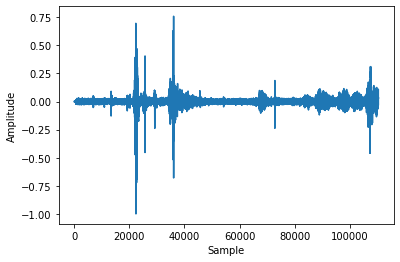

In [ ]:
plt.plot(y)
# label the axes
plt.ylabel("Amplitude")
plt.xlabel("Sample")
# set the title  
#plt.title("Sample Wav")
# display the plot
plt.show()

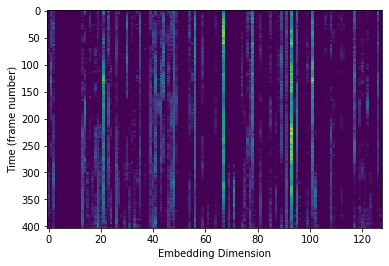

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(resdict['embedding'], 
           aspect='auto')
plt.xlabel('Embedding Dimension')
plt.ylabel('Time (frame number)')
#plt.title('Embedded Representation for Sinusoid Test Signal')
plt.grid(False);

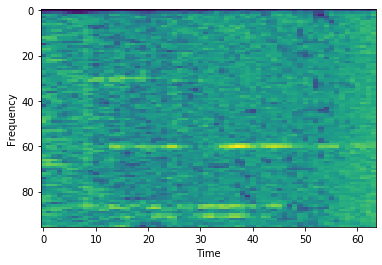

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(mfcc, 
           aspect='auto')
plt.xlabel('Time')
plt.ylabel('Frequency')
#plt.title('Mel Frequency Cepstral Coefficients (MFCC)')
plt.grid(False);

Text(0.5, 1.0, 'Log Spectrogram')

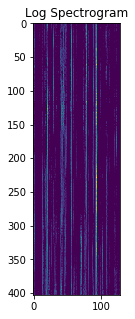

In [ ]:
plt.figure(figsize = (10, ))
plt.imshow(resdict['embedding'])
plt.title('Log Spectrogram')

Text(0.5, 1.0, 'Log Spectrogram')

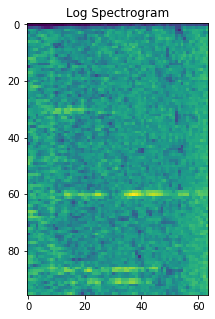

In [ ]:
plt.figure(figsize = (5, 5))
plt.imshow(mfcc)
plt.title('Log Spectrogram')

In [ ]:
plt.imshow(input_batch[0], 
           aspect='auto', cmap='binary')
plt.xlabel('MFCC')
plt.ylabel('Time (frame number)')
plt.title('MFCC')
plt.grid(False);

NameError: ignored

In [ ]:
# Note : Tested with Chrome 66 -- might not work with all browsers :-(

# Let's visualize our graph!
# Tip: to make your graph more readable you can add a
# name="..." parameter to the individual Ops.

# src: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb

import numpy as np
import tensorflow as tf
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))